## Import thư viện

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os

## Model

In [2]:
class MLP(nn.Module):
    def __init__(self, image_size, num_layers, hidden_channels, num_classes=100):
        super(MLP, self).__init__()
        self.in_channels = image_size * image_size * 3
        self.flatten = nn.Flatten()
        self.layers = self.make_layer(num_classes, num_layers, hidden_channels)


    def make_layer(self, out_channels, num_layers, hidden_channels):
        layers = []
        for idx in range(num_layers):
            layers.extend([nn.Linear(self.in_channels, hidden_channels[idx]),
                           nn.ReLU(inplace=True)])
            self.in_channels = hidden_channels[idx]
            layers.append(nn.Dropout(0.5))
        layers.append(nn.Linear(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

In [3]:
model = MLP(32, 3, [256, 512, 256])
torchsummary.summary(model)
x = torch.randn(5, 3, 32, 32)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       786,688
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       131,584
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       131,328
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      25,700
Total params: 1,075,300
Trainable params: 1,075,300
Non-trainable params: 0


torch.Size([5, 100])

## Cifar100

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 169M/169M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


### Config

In [9]:
checkpoint_id = 1
folder_path = f'./MLP/Cifar100/checkpoint{checkpoint_id}/'
image_size = 32
num_layers = 3
hidden_channels = [256, 512, 256]
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "image_size": image_size,
    "num_layers": num_layers,
    "hidden_channels": hidden_channels,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [10]:
model = MLP(image_size, num_layers, hidden_channels, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader), epochs=num_epochs)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=100, bias=True)
    (7): Dropout(p=0.3, inplace=False)
  )
)


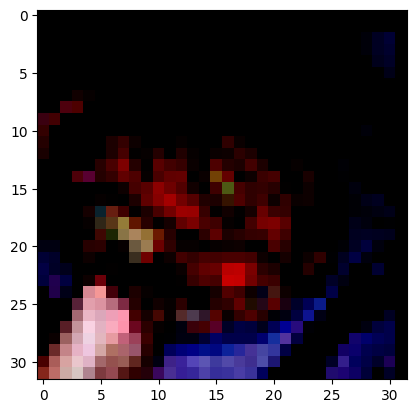

In [11]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

image = images[0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [12]:
print(f'Size: {image.shape}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(trainset.classes)}')

Size: (32, 32, 3)
Train: 50000
Test: 10000
Classes: 100


### Train, test

In [13]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # print(i)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)


  1%|          | 1/100 [00:18<31:11, 18.91s/it]

Epoch [1/100], Loss: 4.5126


  2%|▏         | 2/100 [00:39<32:34, 19.95s/it]

Epoch [2/100], Loss: 4.2697


  3%|▎         | 3/100 [00:58<31:36, 19.55s/it]

Epoch [3/100], Loss: 4.1687


  4%|▍         | 4/100 [01:17<30:31, 19.08s/it]

Epoch [4/100], Loss: 4.1021


  5%|▌         | 5/100 [01:35<29:52, 18.87s/it]

Epoch [5/100], Loss: 4.0585


  6%|▌         | 6/100 [01:58<31:53, 20.36s/it]

Epoch [6/100], Loss: 4.0249


  7%|▋         | 7/100 [02:17<30:45, 19.84s/it]

Epoch [7/100], Loss: 3.9986


  8%|▊         | 8/100 [02:36<29:45, 19.41s/it]

Epoch [8/100], Loss: 3.9734


  9%|▉         | 9/100 [02:54<29:03, 19.16s/it]

Epoch [9/100], Loss: 3.9541


 10%|█         | 10/100 [03:12<28:21, 18.91s/it]

Epoch [10/100], Loss: 3.9381


 11%|█         | 11/100 [03:32<28:22, 19.13s/it]

Epoch [11/100], Loss: 3.9198


 12%|█▏        | 12/100 [03:51<27:54, 19.02s/it]

Epoch [12/100], Loss: 3.9113


 13%|█▎        | 13/100 [04:09<27:20, 18.86s/it]

Epoch [13/100], Loss: 3.8877


 14%|█▍        | 14/100 [04:28<26:50, 18.73s/it]

Epoch [14/100], Loss: 3.8771


 15%|█▌        | 15/100 [04:46<26:19, 18.58s/it]

Epoch [15/100], Loss: 3.8639


 16%|█▌        | 16/100 [05:05<26:19, 18.81s/it]

Epoch [16/100], Loss: 3.8524


 17%|█▋        | 17/100 [05:25<26:15, 18.98s/it]

Epoch [17/100], Loss: 3.8392


 18%|█▊        | 18/100 [05:43<25:40, 18.78s/it]

Epoch [18/100], Loss: 3.8230


 19%|█▉        | 19/100 [06:02<25:13, 18.69s/it]

Epoch [19/100], Loss: 3.8169


 20%|██        | 20/100 [06:20<24:37, 18.47s/it]

Epoch [20/100], Loss: 3.8024


 21%|██        | 21/100 [06:39<24:43, 18.78s/it]

Epoch [21/100], Loss: 3.7977


 22%|██▏       | 22/100 [07:01<25:37, 19.71s/it]

Epoch [22/100], Loss: 3.7892


 23%|██▎       | 23/100 [07:19<24:51, 19.36s/it]

Epoch [23/100], Loss: 3.7907


 24%|██▍       | 24/100 [07:38<24:12, 19.12s/it]

Epoch [24/100], Loss: 3.7778


 25%|██▌       | 25/100 [07:57<23:58, 19.18s/it]

Epoch [25/100], Loss: 3.7701


 26%|██▌       | 26/100 [08:18<24:08, 19.57s/it]

Epoch [26/100], Loss: 3.7529


 27%|██▋       | 27/100 [08:36<23:29, 19.30s/it]

Epoch [27/100], Loss: 3.7401


 28%|██▊       | 28/100 [08:55<23:01, 19.18s/it]

Epoch [28/100], Loss: 3.7315


 29%|██▉       | 29/100 [09:14<22:36, 19.10s/it]

Epoch [29/100], Loss: 3.7285


 30%|███       | 30/100 [09:34<22:27, 19.24s/it]

Epoch [30/100], Loss: 3.7279


 31%|███       | 31/100 [09:55<22:39, 19.71s/it]

Epoch [31/100], Loss: 3.7204


 32%|███▏      | 32/100 [10:14<22:02, 19.45s/it]

Epoch [32/100], Loss: 3.7106


 33%|███▎      | 33/100 [10:32<21:30, 19.27s/it]

Epoch [33/100], Loss: 3.7043


 34%|███▍      | 34/100 [10:51<20:59, 19.09s/it]

Epoch [34/100], Loss: 3.7050


 35%|███▌      | 35/100 [11:11<20:55, 19.32s/it]

Epoch [35/100], Loss: 3.6941


 36%|███▌      | 36/100 [11:31<20:47, 19.49s/it]

Epoch [36/100], Loss: 3.6886


 37%|███▋      | 37/100 [11:52<21:02, 20.03s/it]

Epoch [37/100], Loss: 3.6785


 38%|███▊      | 38/100 [12:11<20:21, 19.70s/it]

Epoch [38/100], Loss: 3.6769


 39%|███▉      | 39/100 [12:31<20:02, 19.71s/it]

Epoch [39/100], Loss: 3.6651


 40%|████      | 40/100 [12:51<19:55, 19.92s/it]

Epoch [40/100], Loss: 3.6611


 41%|████      | 41/100 [13:10<19:15, 19.58s/it]

Epoch [41/100], Loss: 3.6577


 42%|████▏     | 42/100 [13:28<18:33, 19.19s/it]

Epoch [42/100], Loss: 3.6519


 43%|████▎     | 43/100 [13:46<17:55, 18.86s/it]

Epoch [43/100], Loss: 3.6535


 44%|████▍     | 44/100 [14:05<17:31, 18.78s/it]

Epoch [44/100], Loss: 3.6482


 45%|████▌     | 45/100 [14:24<17:20, 18.92s/it]

Epoch [45/100], Loss: 3.6413


 46%|████▌     | 46/100 [14:42<16:47, 18.66s/it]

Epoch [46/100], Loss: 3.6375


 47%|████▋     | 47/100 [15:00<16:21, 18.51s/it]

Epoch [47/100], Loss: 3.6233


 48%|████▊     | 48/100 [15:19<15:59, 18.45s/it]

Epoch [48/100], Loss: 3.6293


 49%|████▉     | 49/100 [15:37<15:34, 18.32s/it]

Epoch [49/100], Loss: 3.6187


 50%|█████     | 50/100 [15:56<15:26, 18.53s/it]

Epoch [50/100], Loss: 3.6161


 51%|█████     | 51/100 [16:15<15:12, 18.63s/it]

Epoch [51/100], Loss: 3.6073


 52%|█████▏    | 52/100 [16:34<15:13, 19.02s/it]

Epoch [52/100], Loss: 3.6082


 53%|█████▎    | 53/100 [16:53<14:40, 18.73s/it]

Epoch [53/100], Loss: 3.6045


 54%|█████▍    | 54/100 [17:11<14:13, 18.55s/it]

Epoch [54/100], Loss: 3.5940


 55%|█████▌    | 55/100 [17:29<13:50, 18.46s/it]

Epoch [55/100], Loss: 3.5989


 56%|█████▌    | 56/100 [17:48<13:41, 18.67s/it]

Epoch [56/100], Loss: 3.5957


 57%|█████▋    | 57/100 [18:07<13:22, 18.66s/it]

Epoch [57/100], Loss: 3.5928


 58%|█████▊    | 58/100 [18:25<12:56, 18.50s/it]

Epoch [58/100], Loss: 3.5833


 59%|█████▉    | 59/100 [18:43<12:33, 18.39s/it]

Epoch [59/100], Loss: 3.5768


 60%|██████    | 60/100 [19:01<12:09, 18.23s/it]

Epoch [60/100], Loss: 3.5798


 61%|██████    | 61/100 [19:19<11:51, 18.25s/it]

Epoch [61/100], Loss: 3.5708


 62%|██████▏   | 62/100 [19:39<11:50, 18.70s/it]

Epoch [62/100], Loss: 3.5675


 63%|██████▎   | 63/100 [19:57<11:28, 18.62s/it]

Epoch [63/100], Loss: 3.5664


 64%|██████▍   | 64/100 [20:15<11:03, 18.44s/it]

Epoch [64/100], Loss: 3.5642


 65%|██████▌   | 65/100 [20:34<10:43, 18.39s/it]

Epoch [65/100], Loss: 3.5541


 66%|██████▌   | 66/100 [20:52<10:20, 18.25s/it]

Epoch [66/100], Loss: 3.5587


 67%|██████▋   | 67/100 [21:10<10:08, 18.45s/it]

Epoch [67/100], Loss: 3.5423


 68%|██████▊   | 68/100 [21:33<10:28, 19.63s/it]

Epoch [68/100], Loss: 3.5517


 69%|██████▉   | 69/100 [21:51<09:54, 19.18s/it]

Epoch [69/100], Loss: 3.5404


 70%|███████   | 70/100 [22:09<09:26, 18.88s/it]

Epoch [70/100], Loss: 3.5395


 71%|███████   | 71/100 [22:27<09:02, 18.70s/it]

Epoch [71/100], Loss: 3.5454


 72%|███████▏  | 72/100 [22:47<08:46, 18.82s/it]

Epoch [72/100], Loss: 3.5298


 73%|███████▎  | 73/100 [23:05<08:27, 18.81s/it]

Epoch [73/100], Loss: 3.5332


 74%|███████▍  | 74/100 [23:23<08:03, 18.58s/it]

Epoch [74/100], Loss: 3.5300


 75%|███████▌  | 75/100 [23:42<07:42, 18.50s/it]

Epoch [75/100], Loss: 3.5245


 76%|███████▌  | 76/100 [24:00<07:20, 18.37s/it]

Epoch [76/100], Loss: 3.5181


 77%|███████▋  | 77/100 [24:18<07:00, 18.28s/it]

Epoch [77/100], Loss: 3.5189


 78%|███████▊  | 78/100 [24:37<06:48, 18.58s/it]

Epoch [78/100], Loss: 3.5192


 79%|███████▉  | 79/100 [24:56<06:33, 18.71s/it]

Epoch [79/100], Loss: 3.5059


 80%|████████  | 80/100 [25:14<06:11, 18.58s/it]

Epoch [80/100], Loss: 3.5028


 81%|████████  | 81/100 [25:33<05:51, 18.50s/it]

Epoch [81/100], Loss: 3.5075


 82%|████████▏ | 82/100 [25:51<05:32, 18.49s/it]

Epoch [82/100], Loss: 3.5029


 83%|████████▎ | 83/100 [26:11<05:19, 18.82s/it]

Epoch [83/100], Loss: 3.5007


 84%|████████▍ | 84/100 [26:31<05:09, 19.37s/it]

Epoch [84/100], Loss: 3.4980


 85%|████████▌ | 85/100 [26:50<04:46, 19.13s/it]

Epoch [85/100], Loss: 3.5067


 86%|████████▌ | 86/100 [27:08<04:23, 18.79s/it]

Epoch [86/100], Loss: 3.4867


 87%|████████▋ | 87/100 [27:26<04:02, 18.62s/it]

Epoch [87/100], Loss: 3.5015


 88%|████████▊ | 88/100 [27:44<03:40, 18.41s/it]

Epoch [88/100], Loss: 3.4865


 89%|████████▉ | 89/100 [28:02<03:21, 18.33s/it]

Epoch [89/100], Loss: 3.4862


 90%|█████████ | 90/100 [28:22<03:07, 18.75s/it]

Epoch [90/100], Loss: 3.4870


 91%|█████████ | 91/100 [28:41<02:48, 18.70s/it]

Epoch [91/100], Loss: 3.4817


 92%|█████████▏| 92/100 [28:59<02:27, 18.46s/it]

Epoch [92/100], Loss: 3.4731


 93%|█████████▎| 93/100 [29:17<02:08, 18.37s/it]

Epoch [93/100], Loss: 3.4786


 94%|█████████▍| 94/100 [29:35<01:49, 18.29s/it]

Epoch [94/100], Loss: 3.4681


 95%|█████████▌| 95/100 [29:53<01:31, 18.37s/it]

Epoch [95/100], Loss: 3.4721


 96%|█████████▌| 96/100 [30:13<01:15, 18.82s/it]

Epoch [96/100], Loss: 3.4620


 97%|█████████▋| 97/100 [30:31<00:55, 18.57s/it]

Epoch [97/100], Loss: 3.4727


 98%|█████████▊| 98/100 [30:49<00:36, 18.46s/it]

Epoch [98/100], Loss: 3.4674


 99%|█████████▉| 99/100 [31:10<00:19, 19.07s/it]

Epoch [99/100], Loss: 3.4584


100%|██████████| 100/100 [31:28<00:00, 18.89s/it]

Epoch [100/100], Loss: 3.4475


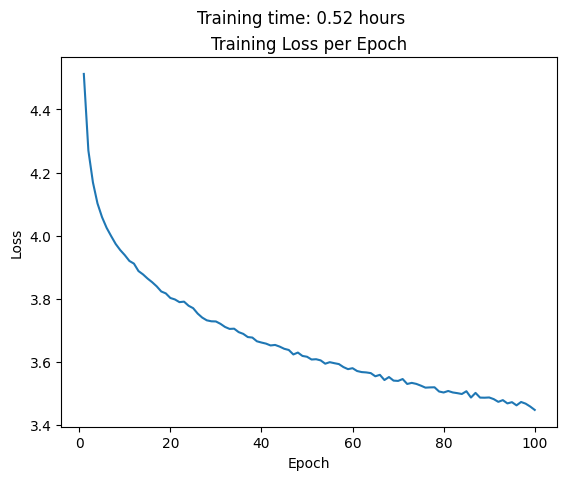

In [14]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [15]:
evaluate(model, testloader, device, folder_path)

Accuracy: 23.09%
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.61      0.38       100
           1       0.29      0.24      0.26       100
           2       0.14      0.08      0.10       100
           3       0.16      0.14      0.15       100
           4       0.11      0.02      0.03       100
           5       0.18      0.18      0.18       100
           6       0.21      0.19      0.20       100
           7       0.28      0.24      0.26       100
           8       0.29      0.05      0.09       100
           9       0.30      0.32      0.31       100
          10       0.07      0.05      0.06       100
          11       0.10      0.14      0.12       100
          12       0.22      0.13      0.16       100
          13       0.15      0.19      0.17       100
          14       0.08      0.24      0.12       100
          15       0.15      0.12      0.13       100
          16       0.38      0.13      0.